In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) |>
    rename("age"= X1, "sex" = X2, "chest_pain" = X3, "trestbps" = X4, "chol" = X5, "fasting_bs" = X6, "restecg" = X7, "max_heart_rate" = X8, "exang" = X9, "old_peak" = X10, "peak_slope" = X11, "ca" = X12, "thal" = X13, "predicted" = X14) |>
    mutate(sex = recode(sex, "1" = "male", "0" = "female")) |>
    mutate(chest_pain = recode(chest_pain, "1" = "typical_angina", "2" = "atypical_angina", "3" = "non_anginal_pain", "4" = "asymptomatic")) |>
    mutate(trestbps = as.integer(trestbps)) |>
    mutate(chol = as.integer(chol)) |>
    mutate(fasting_bs = recode(fasting_bs, "1" = "over_120", "0" = "under_120")) |>
    mutate(restecg = recode(restecg, "0" = "normal", "1" = "abnormal", "2" = "hypertrophy")) |>
    mutate(max_heart_rate = as.integer(max_heart_rate)) |>
    mutate(old_peak = as.numeric(old_peak)) |>
    mutate(ca = as.integer(ca)) |>
    mutate(exang = recode(exang, "0" = "no", "1" = "yes")) |>
    mutate(peak_slope = as.integer(peak_slope)) |>
    mutate(thal = recode(thal, "3.0" = "normal", "6.0" = "fixed_defect", "7.0" = "reversable_defect")) |>
    mutate(predicted = as.factor(predicted)) |>
    mutate(predicted = recode(predicted, "0" = "no_cvd", "1" = "cvd", "2" = "cvd", "3" = "cvd", "4" = "cvd")) |>
    na.omit()

heart_split <- initial_split(heart_data, prop = 0.75, strata = predicted)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train

# age + sex + chest_pain + trestbps + chol + max_heart_rate







Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chest_pain,trestbps,chol,fasting_bs,restecg,max_heart_rate,exang,old_peak,peak_slope,ca,thal,predicted
<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<fct>
67,male,asymptomatic,160,286,under_120,hypertrophy,108,yes,1.5,2,3,normal,cvd
62,female,asymptomatic,140,268,under_120,hypertrophy,160,no,3.6,3,2,normal,cvd
53,male,asymptomatic,140,203,over_120,hypertrophy,155,yes,3.1,3,0,reversable_defect,cvd
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,male,atypical_angina,120,240,under_120,normal,169,no,0.0,3,0,normal,no_cvd
55,female,atypical_angina,132,342,under_120,normal,166,no,1.2,1,0,normal,no_cvd
41,male,atypical_angina,120,157,under_120,normal,182,no,0.0,1,0,normal,no_cvd


`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,predicted,count
<chr>,<fct>,<int>
female,no_cvd,53
female,cvd,21
male,no_cvd,67
male,cvd,82


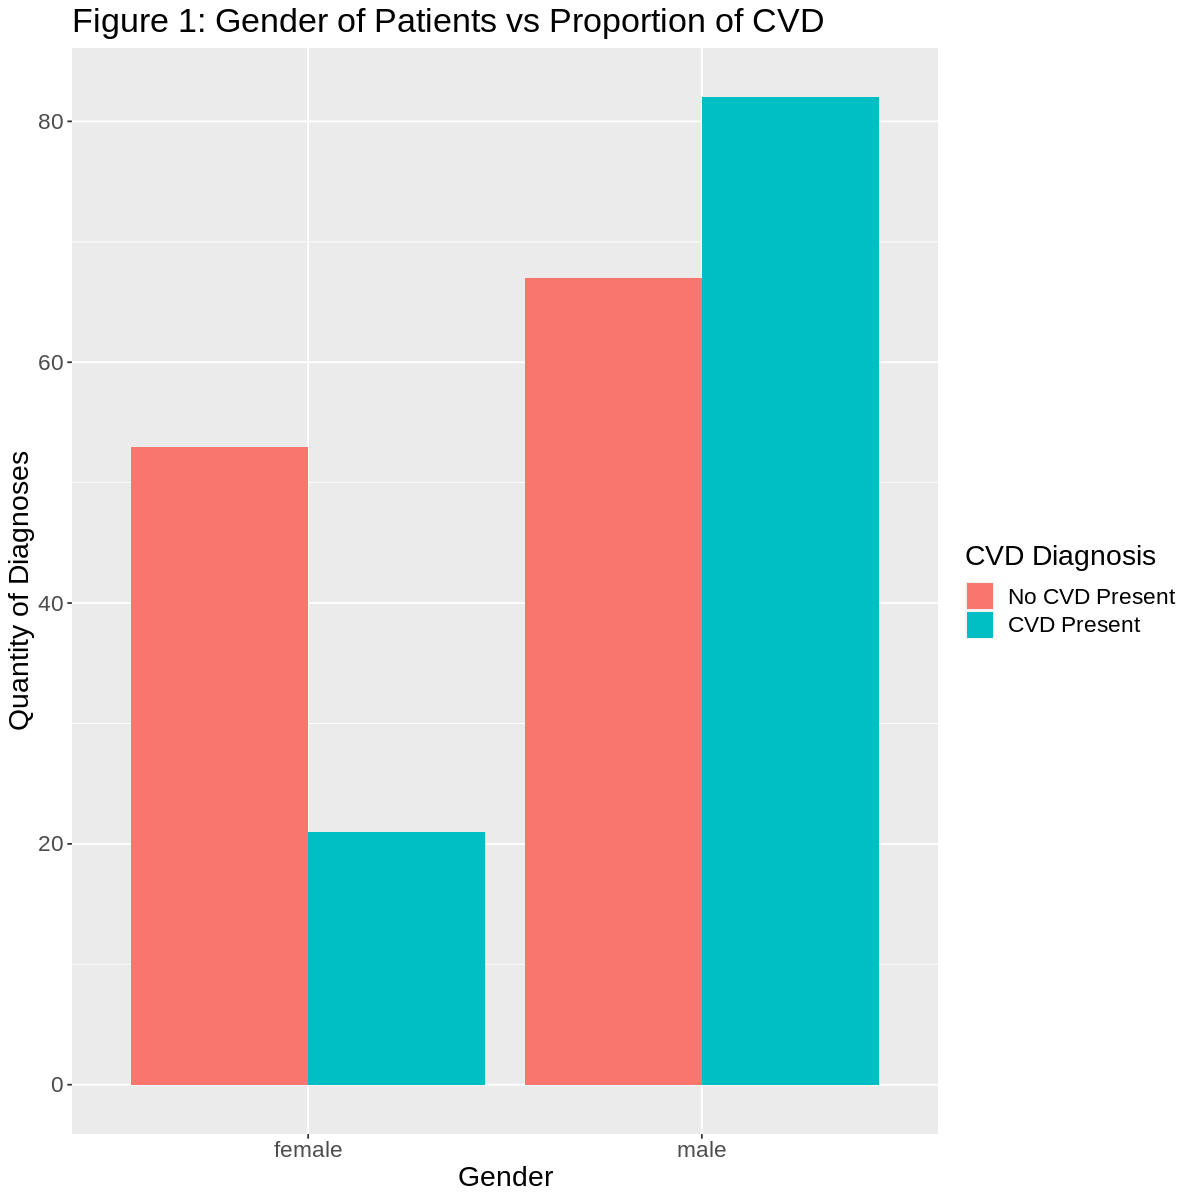

In [3]:
options(repr.plot.width = 10, repr.plot.height = 10)

cvd_sex_count <- heart_train |>
    group_by(sex, predicted) |>
    summarize(count = n())

cvd_sex_plot <- cvd_sex_count|>
    ggplot(aes(x = sex, y = count, fill = predicted)) + 
    geom_bar(stat = "identity", position = "dodge") +
    labs(y = "Quantity of Diagnoses", x = "Gender", fill = "CVD Diagnosis") +
    scale_fill_discrete(labels = c("No CVD Present", "CVD Present")) +
    ggtitle("Figure 1: Gender of Patients vs Proportion of CVD") +
    theme(text = element_text(size = 17)) 

cvd_sex_plot
cvd_sex_count

#  Out of the 149 male patients, roughly 80% were diagnosed with CVD. Out of the 74 female patients, only 40% of the patients were diagnosed with CVD. The two percentages likely signify that males are much more likely to be diagnosed with CVD compared to females. However, another variable could confound the relationship. 

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


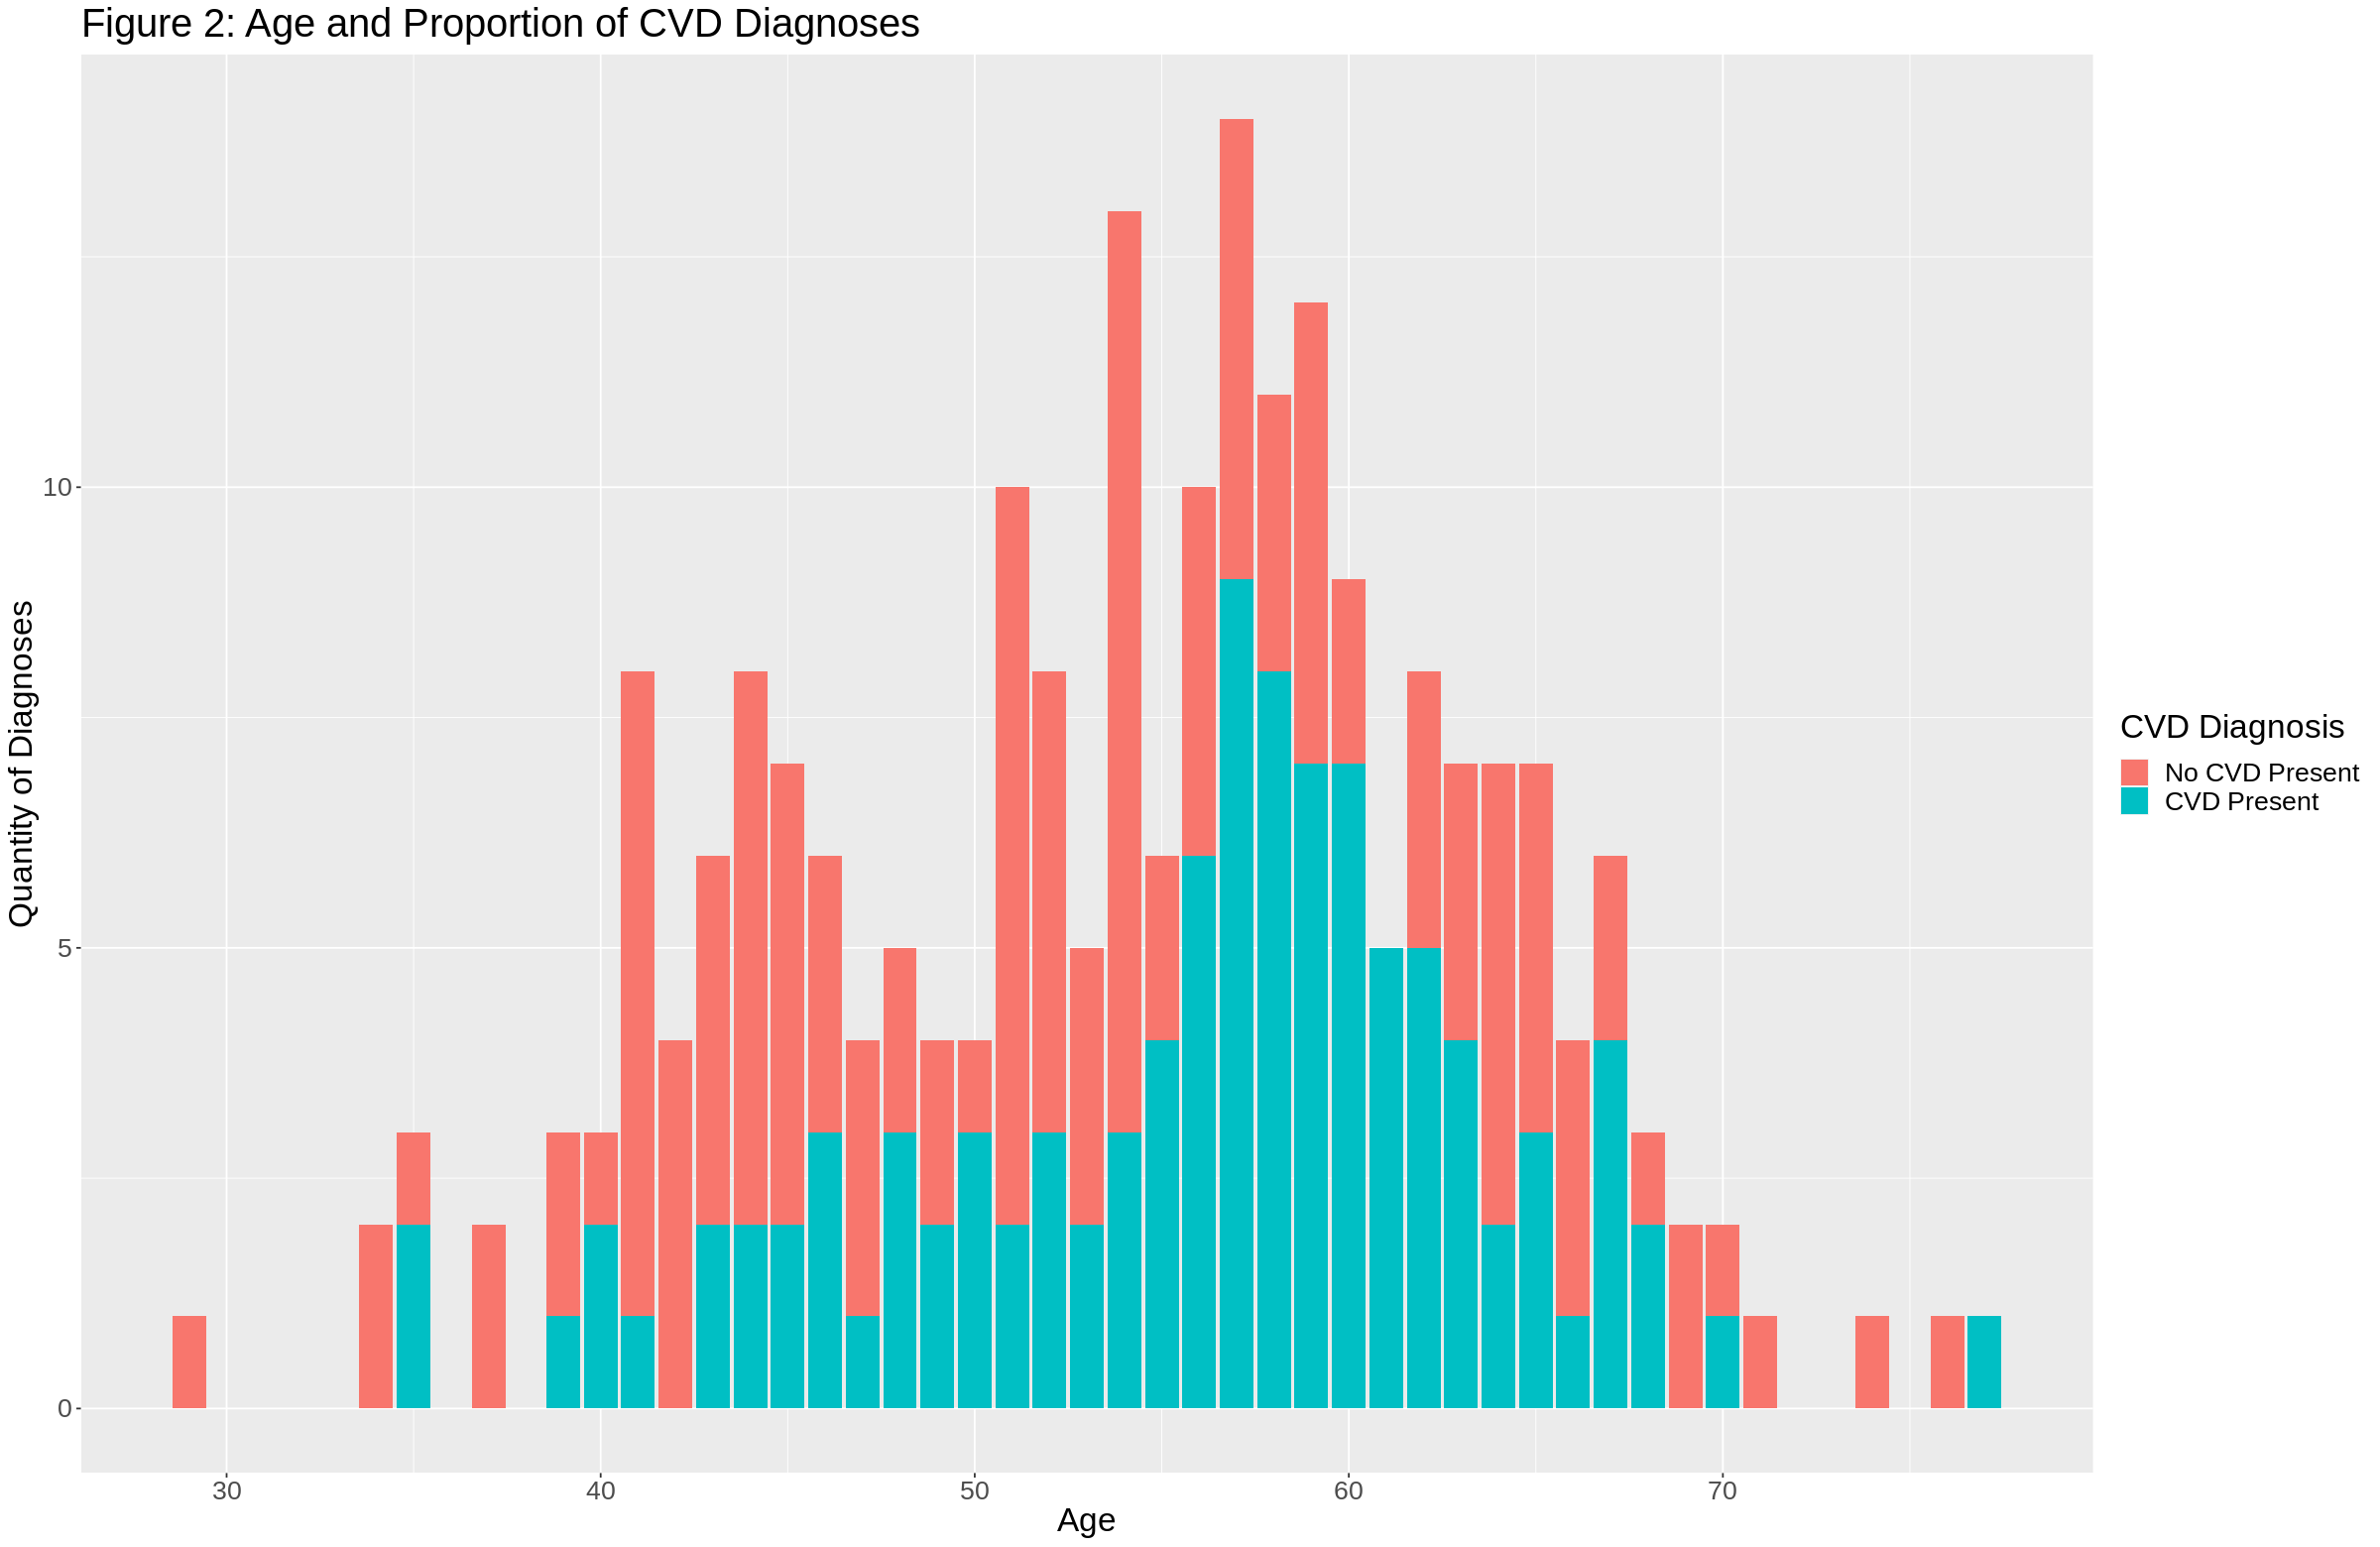

In [4]:
options(repr.plot.width = 20, repr.plot.height = 13) 
cvd_age_count <- heart_train |>
    group_by(age, predicted) |>
    summarize(count = n())

cvd_age_plot <- cvd_age_count |>
    ggplot(aes(x = age, y = count, fill = predicted)) +
    geom_bar(stat = "identity") +
    labs(x = "Age", y = "Quantity of Diagnoses", fill = "CVD Diagnosis") +
    scale_fill_discrete(labels = c("No CVD Present", "CVD Present")) +
    ggtitle("Figure 2: Age and Proportion of CVD Diagnoses") + 
    theme(text = element_text(size = 20)) 

cvd_age_plot

# A large proportion of the sample is diagnosed with CVD around age 60. 

`summarise()` has grouped output by 'predicted'. You can override using the
`.groups` argument.


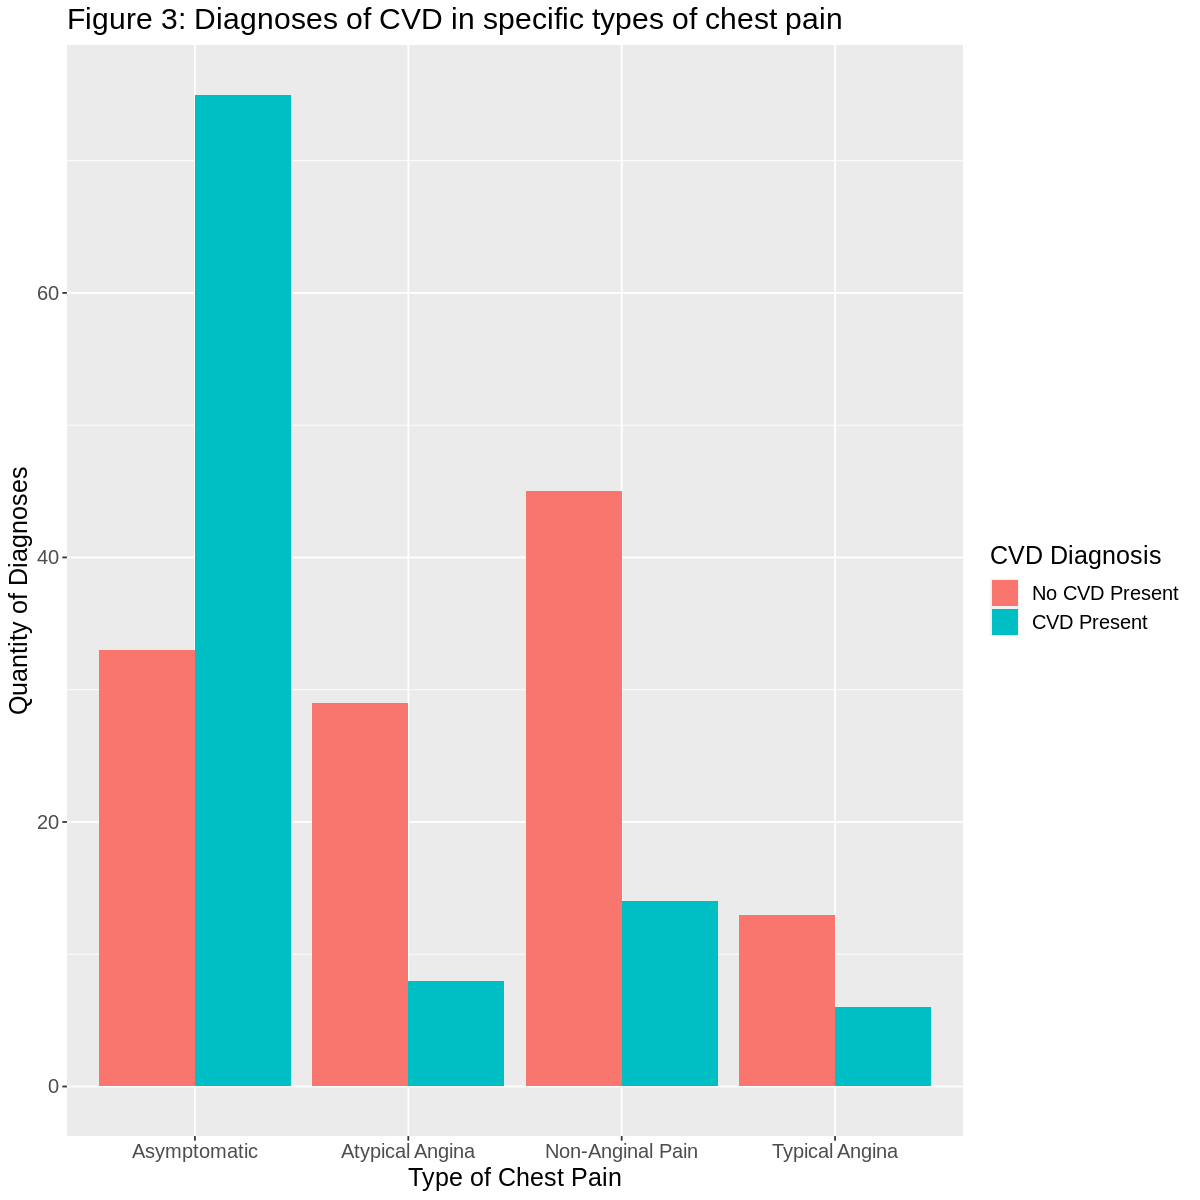

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)

cvd_chest_count <- heart_train |>
    select(predicted, chest_pain) |>
    group_by(predicted, chest_pain) |>
    summarize(count = n())


cvd_chest_plot <- cvd_chest_count |>
    ggplot(aes(x = chest_pain, y = count, fill = predicted)) +
    geom_bar(stat = "identity", position = "dodge") + 
    labs(y = "Quantity of Diagnoses" , x = "Type of Chest Pain", fill = "CVD Diagnosis") +
    scale_fill_discrete(labels = c("No CVD Present", "CVD Present")) +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    ggtitle("Figure 3: Diagnoses of CVD in specific types of chest pain") 
cvd_chest_plot <- cvd_chest_plot + theme(text = element_text(size = 15)) 

cvd_chest_plot

# A large quantity of chest pain patients are diagnosed with silent or asymptomatic chest pain. The relationship between asymptomatic chest pain and the other variables present in the dataset should be investigated to explain the large quantity of asymptomatic chest pain patients. 

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


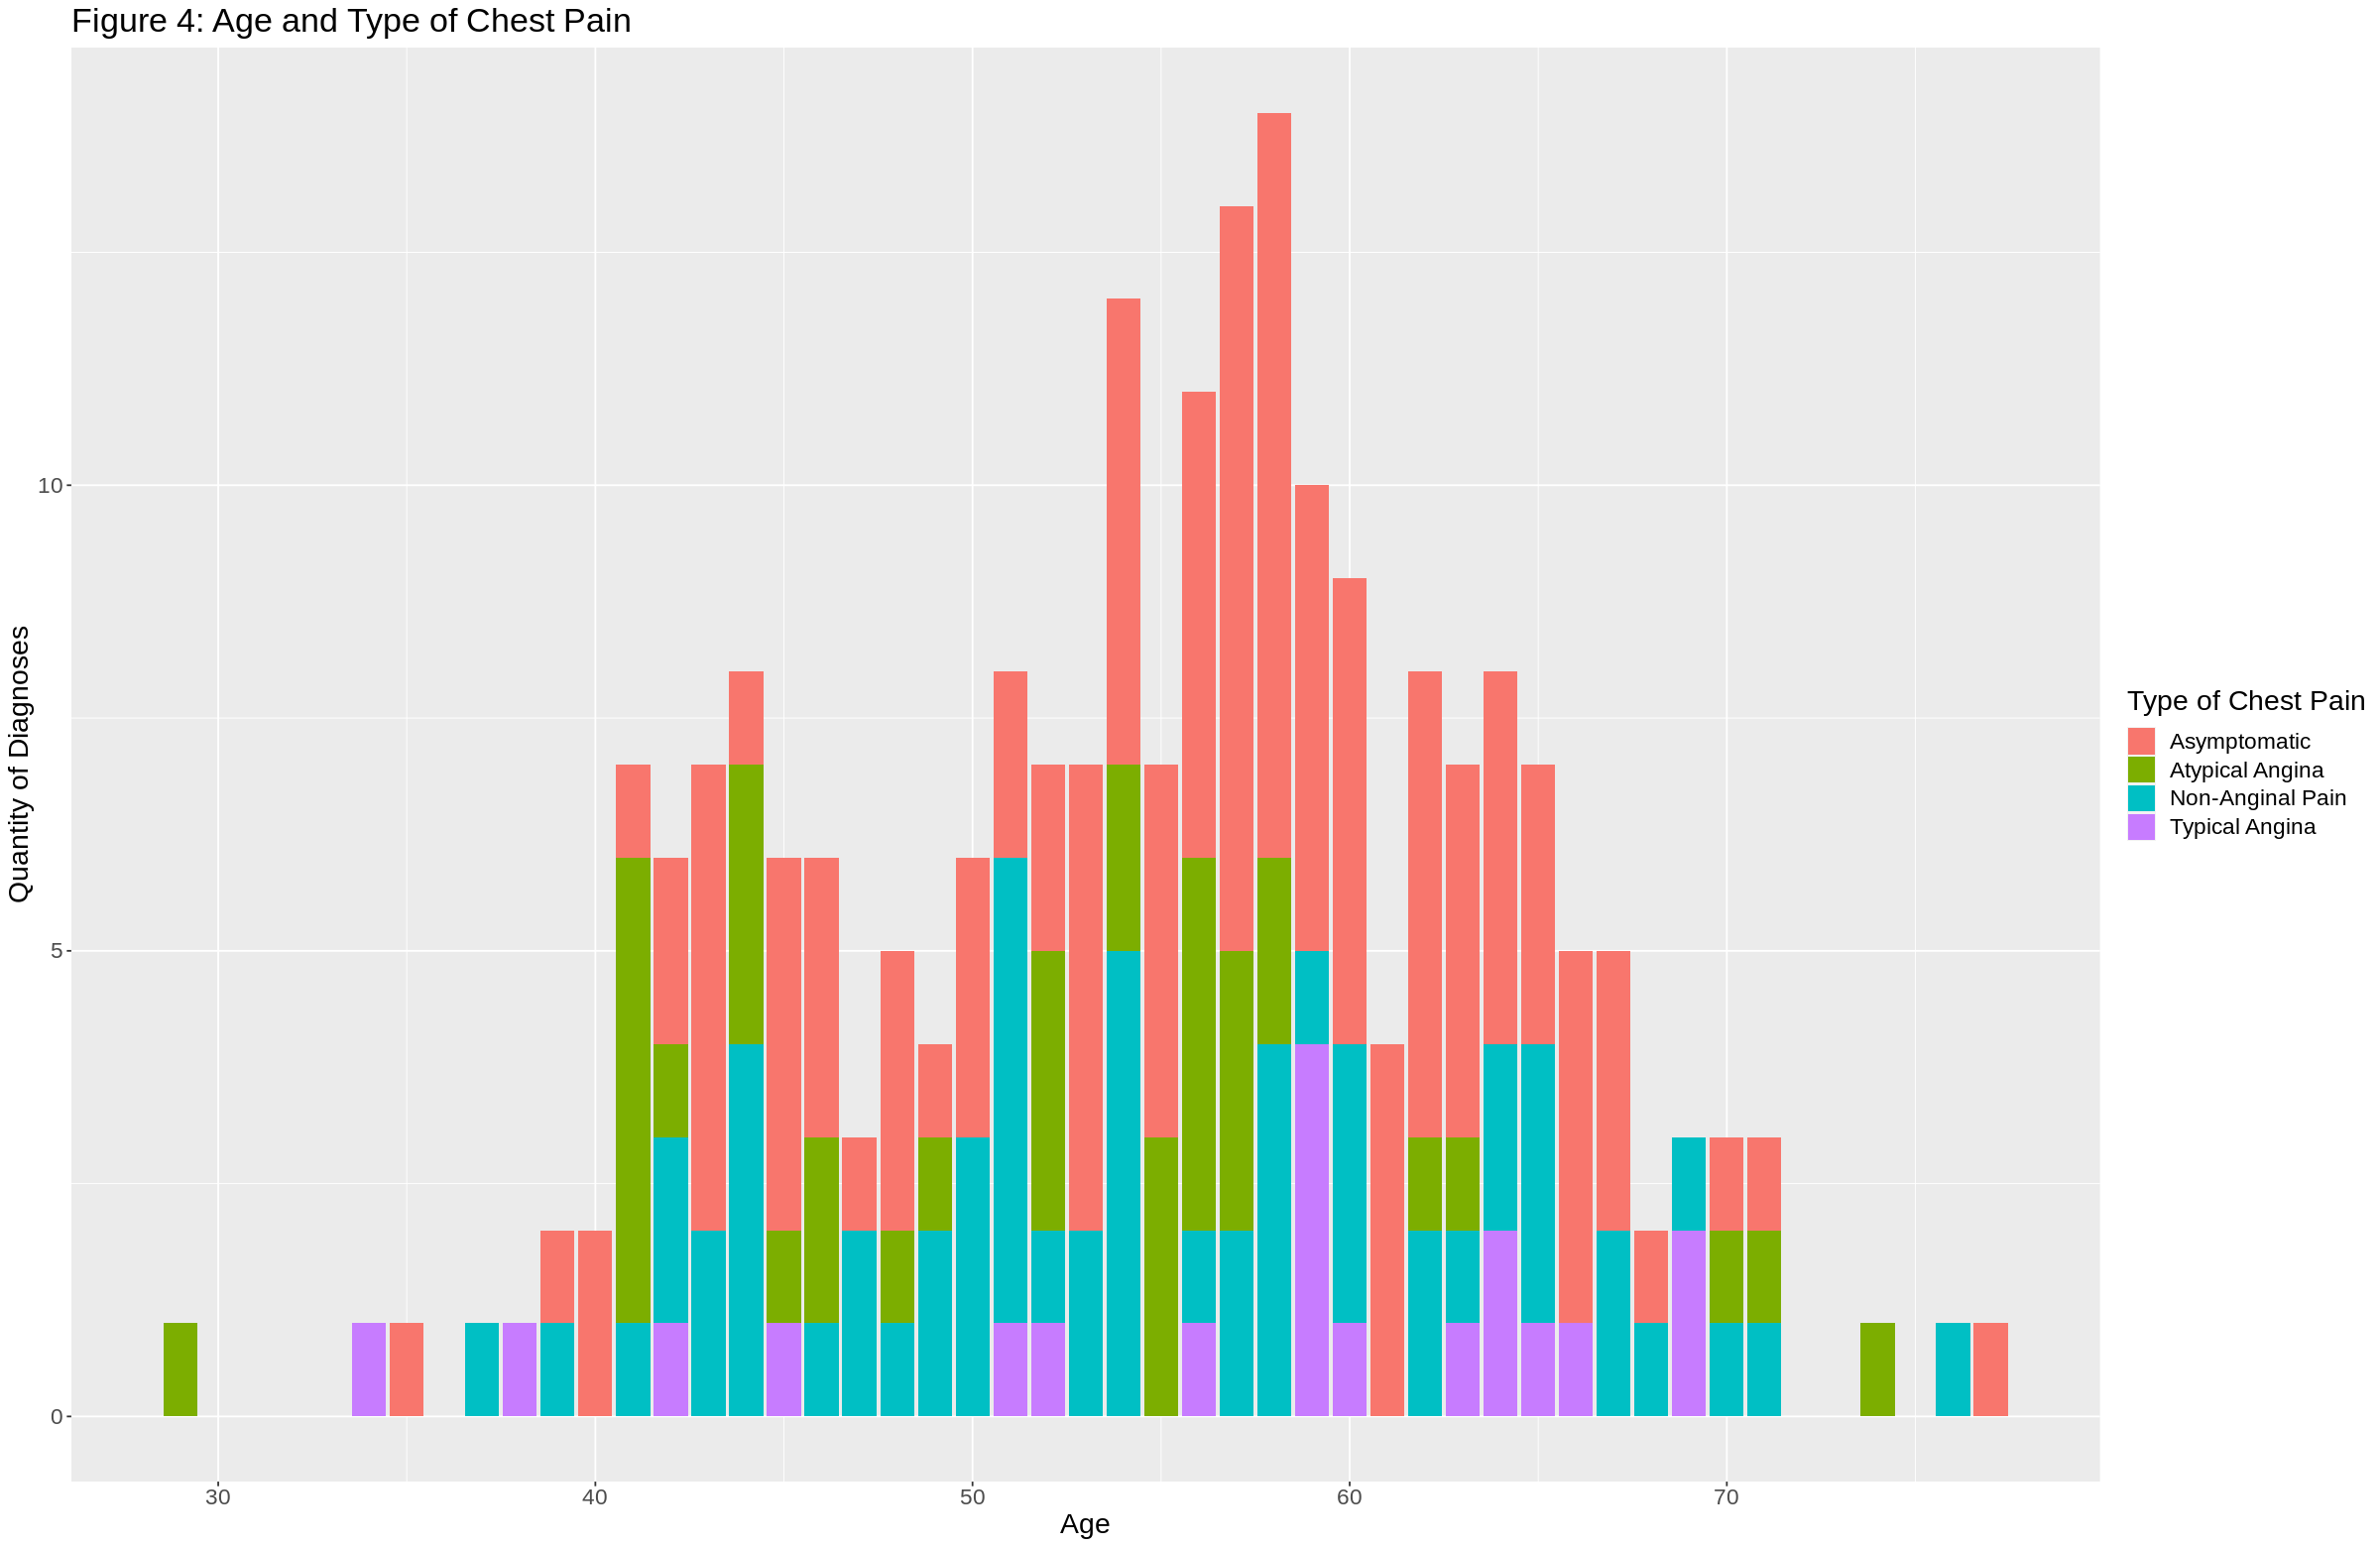

In [7]:
options(repr.plot.width = 20, repr.plot.height = 13)

chest_age_count <- heart_train |>
    select(chest_pain, age) |>
      group_by(age, chest_pain) |>
        summarize(count = n())


chest_age_plot <- chest_age_count |>
    ggplot(aes(x = age, y = count, fill = chest_pain)) +
    geom_bar(stat = "identity") +
    labs(x = "Age", y = "Quantity of Diagnoses", fill = "Type of Chest Pain") +
    scale_fill_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    theme(text = element_text(size = 17)) +
    ggtitle("Figure 4: Age and Type of Chest Pain")
chest_age_plot

# A large proportion of patients diagnosed with asymptomatic chest pain also are around age 60. The relationship could explain why most patients around age 60 are diagnosed with CVD. With the relationships displayed in Figure 2, 3 and 4, a potential logic can be inferred to explain the relationship between asymptomatic chest pain, age and CVD. 

# Potentially, asymptomatic chest pain is more common in people around age 60 and also a prominant symptom of CVD which explains the large proportion of patients around age 60 with CVD and asymptomatic chest pain.  



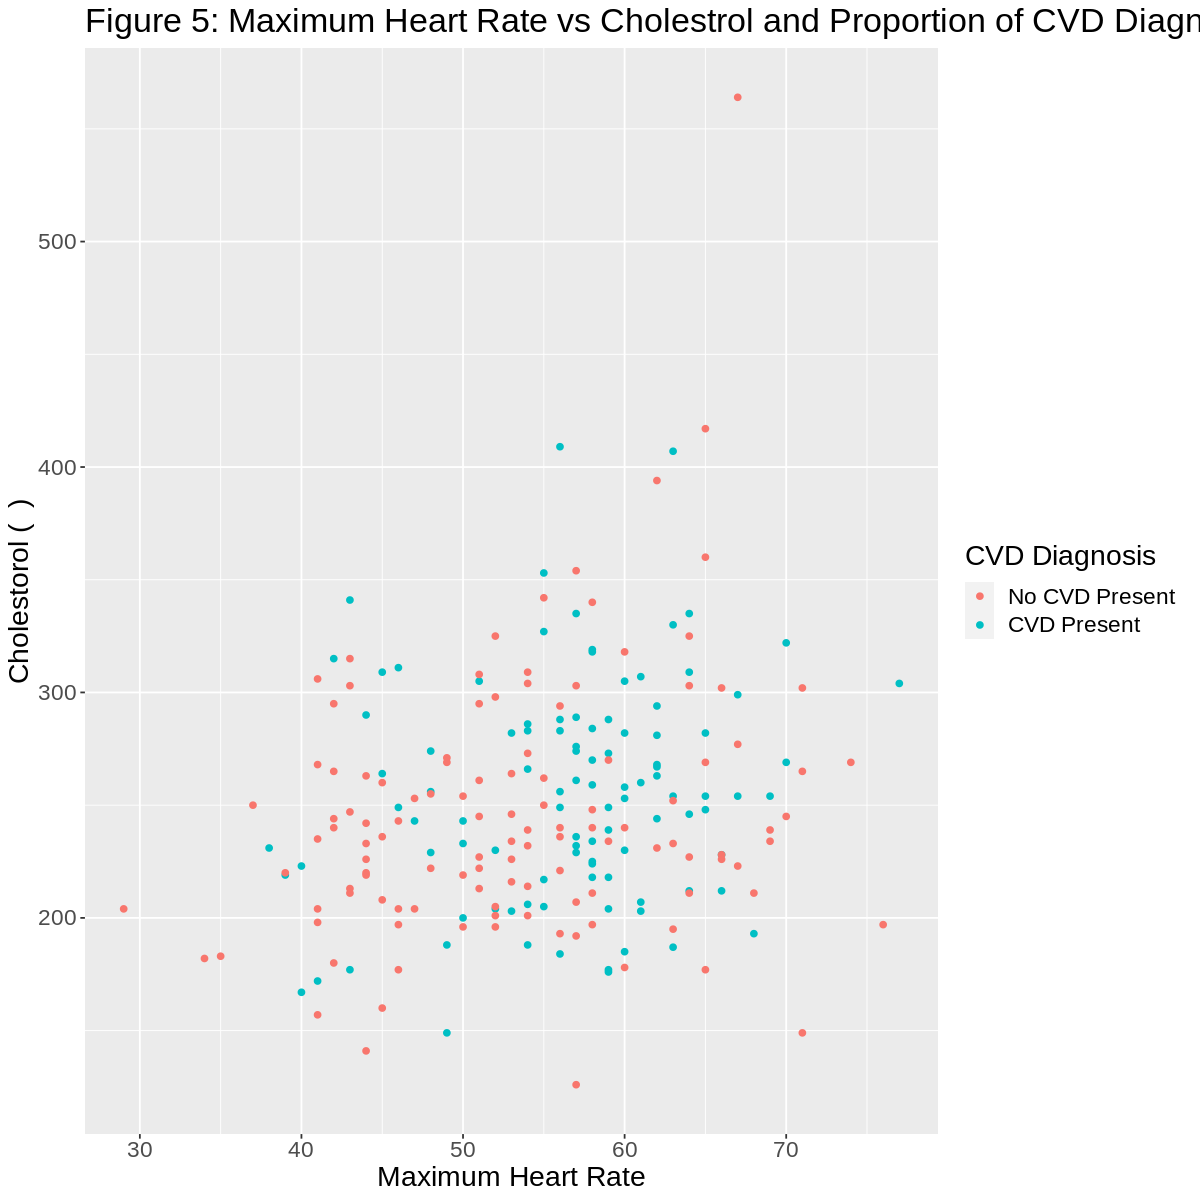

In [8]:
options(repr.plot.width = 10, repr.plot.height = 10)

chol_age_plot <- heart_train |>
    ggplot(aes(x = age, y = chol, color = predicted)) + 
    geom_point() +
    labs(x = "Maximum Heart Rate", y = "Cholestorol (  )", color = "CVD Diagnosis") + 
    scale_color_discrete(labels = c("No CVD Present", "CVD Present")) +
     ggtitle("Figure 5: Maximum Heart Rate vs Cholestrol and Proportion of CVD Diagnoses") + 
    theme(text = element_text(size = 17))
chol_age_plot

# chol leads to CVD as people age when chol is below 300 

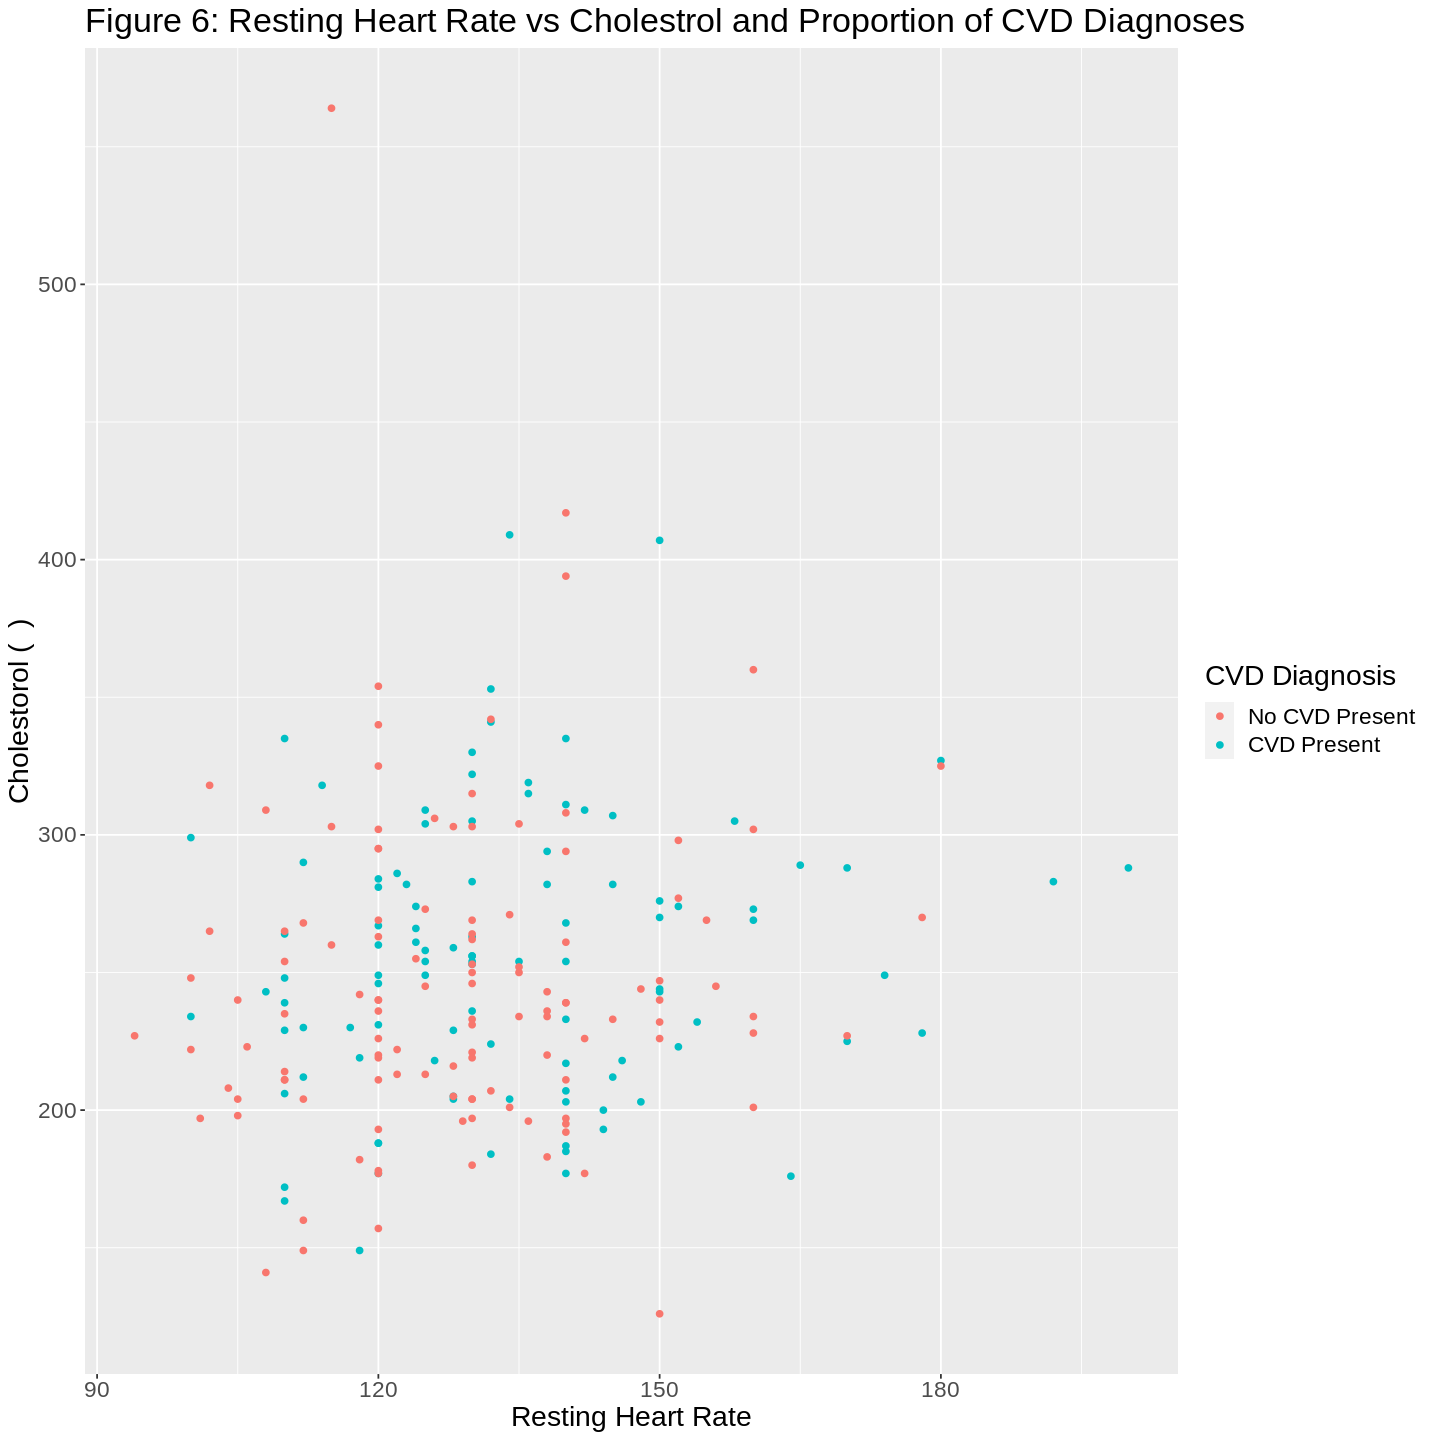

In [9]:
options(repr.plot.width = 12, repr.plot.height = 12)

chol_rest_plot <- heart_train |>
    ggplot(aes(x = trestbps , y = chol, color = predicted)) +
    geom_point() +
    labs(x = "Resting Heart Rate", y = "Cholestorol (  )", color = "CVD Diagnosis") + 
    scale_color_discrete(labels = c("No CVD Present", "CVD Present")) +
    ggtitle("Figure 6: Resting Heart Rate vs Cholestrol and Proportion of CVD Diagnoses") + 
    theme(text = element_text(size = 17))

chol_rest_plot

#chol below 300 and resting around 125 appears to be healthy and likely does not lead to CVD 

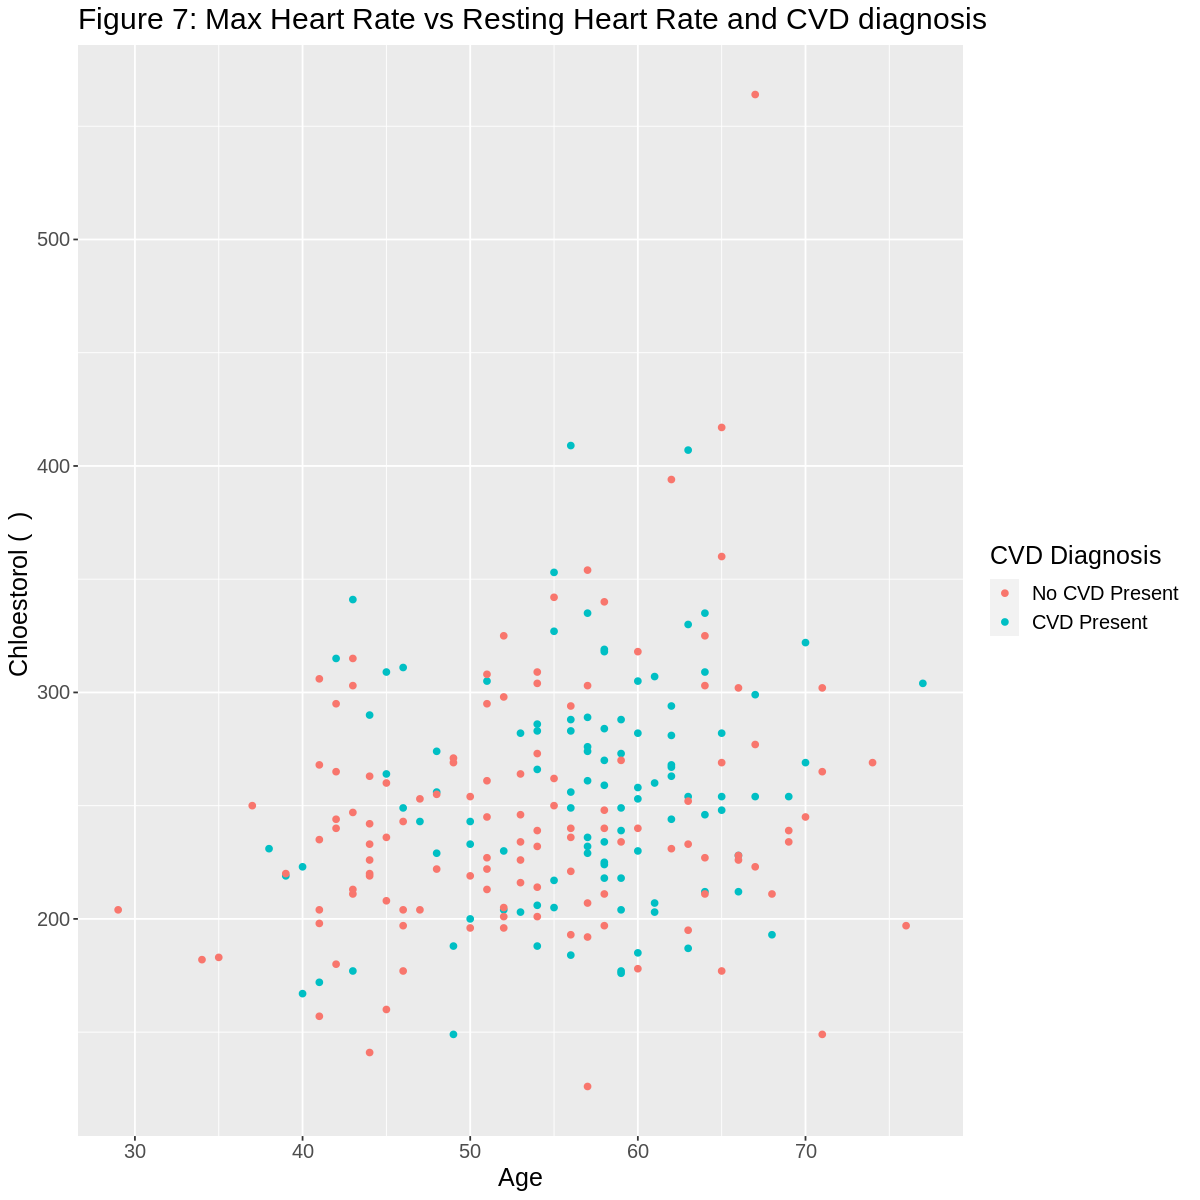

In [10]:
options(repr.plot.width = 10, repr.plot.height = 10)

chol_age_plot <- heart_train |> 
    ggplot(aes(x = age, y =  chol, color = predicted)) +
    geom_point() + 
    scale_color_discrete(labels = c("No CVD Present", "CVD Present")) +
    labs(x = "Age", y = "Chloestorol (  ) ", color = "CVD Diagnosis") + 
    ggtitle("Figure 7: Max Heart Rate vs Resting Heart Rate and CVD diagnosis") +
    theme(text = element_text(size = 15)) 
chol_age_plot

# Chol could increase with age. CVD diagnosis definitley increase with age and low chol cannot help reduce chances of CVD in this case. 

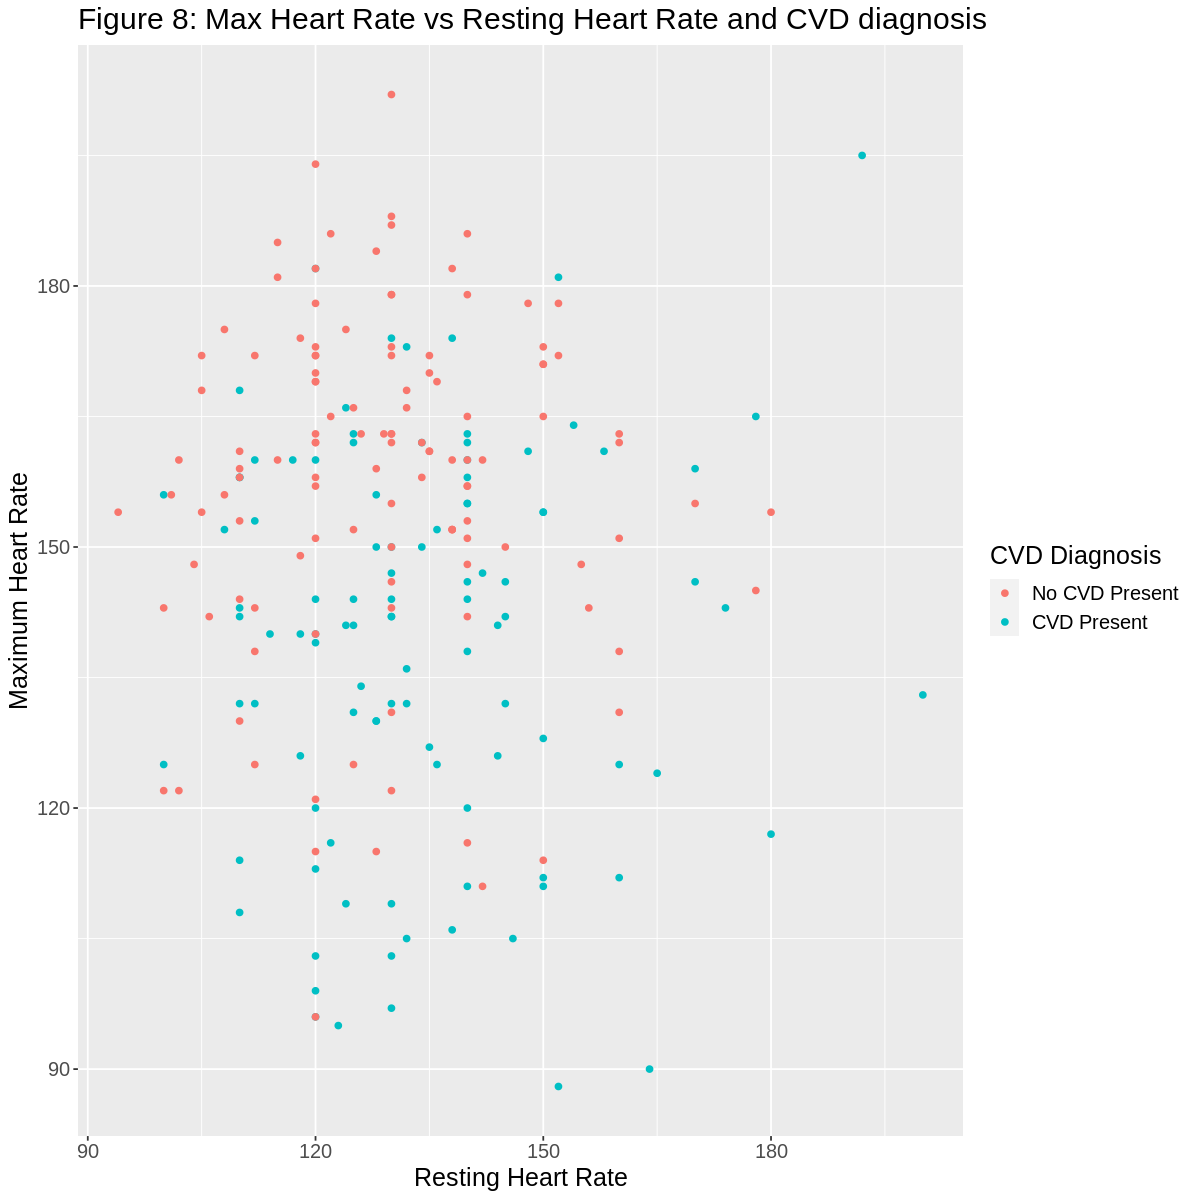

In [11]:
options(repr.plot.width = 10, repr.plot.height = 10)

rest_max_plot <- heart_train |>
    ggplot(aes(x = trestbps, y = max_heart_rate, color = predicted)) + 
    geom_point() +
    scale_color_discrete(labels = c("No CVD Present", "CVD Present")) +
    labs(x = "Resting Heart Rate", y = "Maximum Heart Rate", color = "CVD Diagnosis") + 
    ggtitle("Figure 8: Max Heart Rate vs Resting Heart Rate and CVD diagnosis") +
    theme(text = element_text(size = 15)) 
rest_max_plot

# low max heart rate leads to CVD likely 